# Overview

- Use [Langchain](https://python.langchain.com/en/latest/index.html) to **<font color='orange'>build a chatbot that can answer questions about</font>** [Harry Potter books](https://www.kaggle.com/datasets/hinepo/harry-potter-books-in-pdf-1-7)
- **<font color='orange'>Flexible and customizable RAG pipeline (Retrieval Augmented Generation)</font>**
- Experiment with various LLMs (Large Language Models)
- Use [FAISS vector store](https://python.langchain.com/docs/integrations/vectorstores/faiss) to store text embeddings created with [Sentence Transformers](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) from 🤗. FAISS runs on GPU and it is much faster than Chroma
- Use [Retrieval chain](https://python.langchain.com/docs/modules/data_connection/retrievers/) to retrieve relevant passages from embedded text
- Summarize retrieved passages
- Leverage Kaggle dual GPU (2 * T4) with [Hugging Face Accelerate](https://huggingface.co/docs/accelerate/index)
- Chat UI with [Gradio](https://www.gradio.app/guides/quickstart)

**<font color='green'>No need to create any API key to use this notebook! Everything is open source.</font>**

**<font color='orange'>Don't forget to upvote the notebook if you learn from it or use it!</font>**

### Models

- [TheBloke/wizardLM-7B-HF](https://huggingface.co/TheBloke/wizardLM-7B-HF)
- [daryl149/llama-2-7b-chat-hf](https://huggingface.co/daryl149/llama-2-7b-chat-hf)
- [daryl149/llama-2-13b-chat-hf](https://huggingface.co/daryl149/llama-2-13b-chat-hf)
- [mistralai/Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)

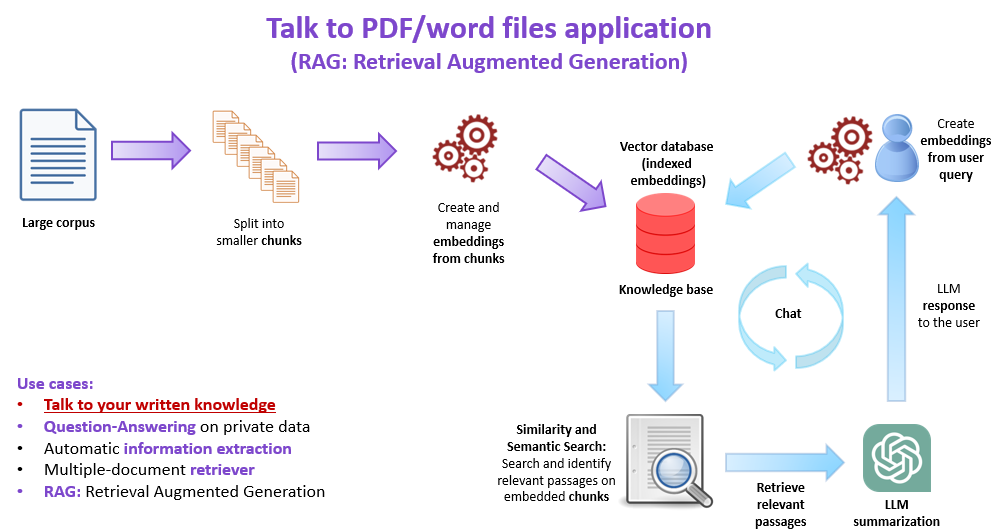

img source: HinePo

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c4608ceb-4488-50e9-d7b8-68c1fde18d94)
GPU 1: Tesla T4 (UUID: GPU-cf887598-25e4-88c0-8fc2-f8bea6d6434e)


# Installs

In [2]:
%%time

from IPython.display import clear_output

! pip install sentence_transformers==2.2.2

! pip install -qq -U langchain
! pip install -qq -U tiktoken
! pip install -qq -U pypdf
! pip install -qq -U faiss-gpu
! pip install -qq -U InstructorEmbedding 

! pip install -qq -U transformers 
! pip install -qq -U accelerate
! pip install -qq -U bitsandbytes

clear_output()

CPU times: user 1.63 s, sys: 429 ms, total: 2.06 s
Wall time: 2min 24s


# Imports

In [3]:
%%time

import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

### loaders
from langchain.document_loaders import PyPDFLoader, DirectoryLoader

### splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

### prompts
from langchain import PromptTemplate, LLMChain

### vector stores
from langchain.vectorstores import FAISS

### models
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings

### retrievers
from langchain.chains import RetrievalQA

import torch
import transformers
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline
)

clear_output()

CPU times: user 8.47 s, sys: 1.46 s, total: 9.93 s
Wall time: 17.5 s


In [4]:
print('langchain:', langchain.__version__)
print('torch:', torch.__version__)
print('transformers:', transformers.__version__)

langchain: 0.1.10
torch: 2.0.0
transformers: 4.38.2


In [5]:
sorted(glob.glob('/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/*'))

['/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 1 - The Sorcerers Stone.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 2 - The Chamber of Secrets.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 3 - The Prisoner of Azkaban.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 5 - The Order of the Phoenix.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf']

# CFG

- CFG class enables easy and organized experimentation 

In [6]:
class CFG:
    # LLMs
    model_name = 'llama2-13b-chat' # wizardlm, llama2-7b-chat, llama2-13b-chat, mistral-7B
    temperature = 0
    top_p = 0.95
    repetition_penalty = 1.15    

    # splitting
    split_chunk_size = 800
    split_overlap = 0
    
    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'    

    # similar passages
    k = 6
    
    # paths
    PDFs_path = '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/'
    Embeddings_path =  '/kaggle/input/faiss-hp-sentence-transformers'
    Output_folder = './harry-potter-vectordb'

# Define model

In [7]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )        

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True
        )
        
        max_len = 1024

    elif model == 'llama2-7b-chat':
        model_repo = 'daryl149/llama-2-7b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )
        
        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )
        
        max_len = 2048

    elif model == 'llama2-13b-chat':
        model_repo = 'daryl149/llama-2-13b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )
                
        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,       
            device_map = 'auto',
            low_cpu_mem_usage = True,
            trust_remote_code = True
        )
        
        max_len = 2048 # 8192

    elif model == 'mistral-7B':
        model_repo = 'mistralai/Mistral-7B-v0.1'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)
        
        bnb_config = BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "nf4",
            bnb_4bit_compute_dtype = torch.float16,
            bnb_4bit_use_double_quant = True,
        )        

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            quantization_config = bnb_config,
            device_map = 'auto',
            low_cpu_mem_usage = True,
        )
        
        max_len = 1024

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [8]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

clear_output()

CPU times: user 34.2 s, sys: 1min, total: 1min 34s
Wall time: 3min 55s


In [9]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    

In [10]:
### check how Accelerate split the model across the available devices (GPUs)
model.hf_device_map

{'model.embed_tokens': 0,
 'model.layers.0': 0,
 'model.layers.1': 0,
 'model.layers.2': 0,
 'model.layers.3': 0,
 'model.layers.4': 0,
 'model.layers.5': 0,
 'model.layers.6': 0,
 'model.layers.7': 0,
 'model.layers.8': 0,
 'model.layers.9': 0,
 'model.layers.10': 0,
 'model.layers.11': 0,
 'model.layers.12': 0,
 'model.layers.13': 0,
 'model.layers.14': 0,
 'model.layers.15': 0,
 'model.layers.16': 0,
 'model.layers.17': 1,
 'model.layers.18': 1,
 'model.layers.19': 1,
 'model.layers.20': 1,
 'model.layers.21': 1,
 'model.layers.22': 1,
 'model.layers.23': 1,
 'model.layers.24': 1,
 'model.layers.25': 1,
 'model.layers.26': 1,
 'model.layers.27': 1,
 'model.layers.28': 1,
 'model.layers.29': 1,
 'model.layers.30': 1,
 'model.layers.31': 1,
 'model.layers.32': 1,
 'model.layers.33': 1,
 'model.layers.34': 1,
 'model.layers.35': 1,
 'model.layers.36': 1,
 'model.layers.37': 1,
 'model.layers.38': 1,
 'model.layers.39': 1,
 'model.norm': 1,
 'lm_head': 1}

# 🤗 pipeline

- Hugging Face pipeline

In [11]:
### hugging face pipeline
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
#     do_sample = True,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

### langchain pipeline
llm = HuggingFacePipeline(pipeline = pipe)

In [12]:
llm

HuggingFacePipeline(pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x795f44be5c60>)

In [13]:
%%time
### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of cool potions and explain what they do"
llm.invoke(query)

CPU times: user 50.8 s, sys: 234 ms, total: 51 s
Wall time: 43 s


'.\n\nSure thing! Here are five examples of cool potions that you might find in a fantasy world, along with their effects:\n\n1. Potion of Healing: This potion restores health to the drinker, healing wounds and injuries. It might also grant temporary immunity to future damage or disease.\n2. Potion of Strength: This potion grants the drinker increased physical strength and endurance for a short period of time, allowing them to lift heavier objects, run faster, and fight longer.\n3. Potion of Speed: This potion allows the drinker to move at incredible speeds for a short period of time, making it easier to escape danger or chase down enemies.\n4. Potion of Invisibility: This potion makes the drinker temporarily invisible, allowing them to sneak past guards, avoid detection by monsters, or steal valuable items without being caught.\n5. Potion of Flight: This potion gives the drinker the ability to fly for a short period of time, allowing them to traverse long distances quickly, reach high

# 🦜🔗 Langchain

- Multiple document retriever with LangChain

In [14]:
CFG.model_name

'llama2-13b-chat'

# Loader

- [Directory loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory) for multiple files
- This step is not necessary if you are just loading the vector database
- This step is necessary if you are creating embeddings. In this case you need to:
    - load de PDF files
    - split into chunks
    - create embeddings
    - save the embeddings in a vector store
    - After that you can just load the saved embeddings to do similarity search with the user query, and then use the LLM to answer the question
    
You can comment out this section if you use the embeddings I already created.

In [15]:
%%time

loader = DirectoryLoader(
    CFG.PDFs_path,
    glob="./*.pdf",
    loader_cls=PyPDFLoader,
    show_progress=True,
    use_multithreading=True
)

documents = loader.load()

100%|██████████| 7/7 [02:17<00:00, 19.69s/it]

CPU times: user 2min 18s, sys: 1.83 s, total: 2min 20s
Wall time: 2min 17s


In [16]:
print(f'We have {len(documents)} pages in total')

We have 4114 pages in total


In [17]:
documents[8].page_content

"8Ron\nP.S. Percy's Head Boy. He got the letter last week.Harry glanced back at the photograph. Percy, who was in his seventh and\nfinal year at Hogwarts, was looking particularly smug. He had pinned hisHead Boy badge to the fez perched jauntily on top of his neat hair, hishorn-rimmed glasses flashing in the Egyptian sun.\nHarry now turned to his present and unwrapped it. Inside was what looked\nlike a miniature glass spinning top. There was another note from Ronbeneath it.\nHarry -- this is a Pocket Sneakoscope. If there's someone untrustworthy\naround, it's supposed to light up and spin. Bill says it's rubbish soldfor wizard tourists and isn't reliable, because it kept lighting up atdinner last night. But he didn't realize Fred and George had put beetlesin his soup.\nBye --RonHarry put the Pocket Sneakoscope on his bedside table, where it stood\nquite still, balanced on its point, reflecting the luminous hands of hisclock. He looked at it happily for a few seconds, then picked up the

# Splitter

- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/reference/modules/document_loaders.html?highlight=RecursiveCharacterTextSplitter#langchain.document_loaders.MWDumpLoader)

In [18]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.split_chunk_size,
    chunk_overlap = CFG.split_overlap
)

texts = text_splitter.split_documents(documents)

print(f'We have created {len(texts)} chunks from {len(documents)} pages')

We have created 10519 chunks from 4114 pages


# Create Embeddings


- Embedd and store the texts in a Vector database (FAISS)
- [LangChain Vector Stores docs](https://python.langchain.com/docs/modules/data_connection/vectorstores/)
- [FAISS - langchain](https://python.langchain.com/docs/integrations/vectorstores/faiss)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks - paper Aug/2019](https://arxiv.org/pdf/1908.10084.pdf)
- [This is a nice 4 minutes video about vector stores](https://www.youtube.com/watch?v=dN0lsF2cvm4)

___

- If you use Chroma vector store it will take ~35 min to create embeddings
- If you use FAISS vector store on GPU it will take just ~3 min

___

We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search. 

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from [here](https://www.kaggle.com/datasets/hinepo/faiss-hp-sentence-transformers).

In [19]:
%%time

### we create the embeddings only if they do not exist yet
if not os.path.exists(CFG.Embeddings_path + '/index.faiss'):

    ### download embeddings model
    embeddings = HuggingFaceInstructEmbeddings(
        model_name = CFG.embeddings_model_repo,
        model_kwargs = {"device": "cuda"}
    )

    ### create embeddings and DB
    vectordb = FAISS.from_documents(
        documents = texts, 
        embedding = embeddings
    )

    ### persist vector database
    vectordb.save_local(f"{CFG.Output_folder}/faiss_index_hp") # save in output folder
#     vectordb.save_local(f"{CFG.Embeddings_path}/faiss_index_hp") # save in input folder

CPU times: user 1.14 ms, sys: 34 µs, total: 1.17 ms
Wall time: 6.14 ms


If creating embeddings, remember that on Kaggle we can not write data to the input folder.

So just write (save) the embeddings to the output folder and then load them from there.

# Load vector database

- After saving the vector database, we just load it from the Kaggle Dataset I mentioned
- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [20]:
%%time

### download embeddings model
embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

### load vector DB embeddings
vectordb = FAISS.load_local(
    CFG.Embeddings_path, # from input folder
#     CFG.Output_folder + '/faiss_index_hp', # from output folder
    embeddings
)

clear_output()

CPU times: user 863 ms, sys: 341 ms, total: 1.2 s
Wall time: 5.45 s


In [21]:
### test if vector DB was loaded correctly
vectordb.similarity_search('magic creatures')

[Document(page_content='“Magic?” he repeated in a whisper. \n“That’s right,” said Dumbledore. \n“It’s … it’s magic, what I can do?” \n“What is it that you can do?” \n“All sorts,” breathed Riddle. A flush of excitement was \nrising up his neck into his hollow cheeks; he looked \nfevered. “I can make things move without touching \nthem. I can make animals do what I want them to do, \nwithout training them. I can make bad things happen \nto people who annoy me. I can make them hurt if I \nwant to.”', metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf', 'page': 302}),
 Document(page_content='91"Shut up, Malfoy," said Harry quietly. Hagrid was looking downcast and\nHarry wanted Hagrid\'s first lesson to be a success.\n"Righ\' then," said Hagrid, who seemed to have lost his thread, "so -- so\nyeh\'ve got yer books an\' -- an\' - - now yeh need the Magical Creatures.Yeah. So I\'ll go an\' get \'em. Hang on... "\nHe strod

# Prompt Template

- Custom prompt

In [22]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template, 
    input_variables = ["context", "question"]
)

In [23]:
# llm_chain = LLMChain(prompt=PROMPT, llm=llm)
# llm_chain

# Retriever chain

- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)

In [24]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever, 
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

In [25]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

[Document(page_content='would warn Hagrid myself, but I am  banished — it would be unwise \nfor me to go too near the forest now — Hagrid has troubles enough, \nwithout a centaurs’ battle.” \n“But — what’s Hagrid attempting to do?” said Harry nervously. \nFirenze looked at Harry impassively. \n“Hagrid has recently rendered me a great service,” said Firenze,', metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 5 - The Order of the Phoenix.pdf', 'page': 619}),
 Document(page_content="wisely. Behind him, Buckbeak spat a few ferret bones onto Hagrid'spillow.", metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 3 - The Prisoner of Azkaban.pdf', 'page': 228}),
 Document(page_content='says Draco Malfoy, a fourth-year student. “We all hate Hagrid, but we’re just too scared to say \nanything.” \nHagrid has no intention of ceasing his campaign \nof intimidation, however. In conversation with a \nDaily Prophet  

In [26]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

[Document(page_content='would warn Hagrid myself, but I am  banished — it would be unwise \nfor me to go too near the forest now — Hagrid has troubles enough, \nwithout a centaurs’ battle.” \n“But — what’s Hagrid attempting to do?” said Harry nervously. \nFirenze looked at Harry impassively. \n“Hagrid has recently rendered me a great service,” said Firenze,', metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 5 - The Order of the Phoenix.pdf', 'page': 619}),
 Document(page_content="Harry could sort of see what Hagrid meant. Once you got over the first\nshock of seeing something that was, half horse, half bird, you startedto appreciate the hippogriffs' gleaming coats, changing smoothly fromfeather to hair, each of them a different color: stormy gray, bronze,", metadata={'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 3 - The Prisoner of Azkaban.pdf', 'page': 91}),
 Document(page_content='CHAPTER  THIRTEEN \n\

# Post-process outputs

- Format llm response
- Cite sources (PDFs)
- Change `width` parameter to format the output

In [27]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    
    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4]
            + ' - page: '
            + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )
    
    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [28]:
def llm_ans(query):
    start = time.time()
    
    llm_response = qa_chain.invoke(query)
    ans = process_llm_response(llm_response)
    
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

# Ask questions

- Question Answering from multiple documents
- Invoke QA Chain
- Talk to your data

In [29]:
CFG.model_name

'llama2-13b-chat'

In [30]:
query = "Which challenges does Harry face during the Triwizard Tournament?"
print(llm_ans(query))

 During the Triwizard Tournament, Harry faces several challenges, including:

* The first task, which involves retrieving a golden egg from a dragon nest.
* The second task, which requires him to navigate a maze while being pursued by a giant spider.
* The third task, which takes place that evening and involves facing his fears and overcoming them.

Sources: 
Harry Potter - Book 4 - The Goblet of Fire - page: 271 
Harry Potter - Book 4 - The Goblet of Fire - page: 237 
Harry Potter - Book 4 - The Goblet of Fire - page: 252 
Harry Potter - Book 2 - The Chamber of Secrets - page: 116 
Harry Potter - Book 4 - The Goblet of Fire - page: 628 
Harry Potter - Book 4 - The Goblet of Fire - page: 279

Time elapsed: 13 s


In [31]:
query = "Is Malfoy an ally of Voldemort?"
print(llm_ans(query))

 Yes, according to the passage, Malfoy is an ally of Voldemort.

Sources: 
Harry Potter - Book 6 - The Half-Blood Prince - page: 716 
Harry Potter - Book 4 - The Goblet of Fire - page: 665 
Harry Potter - Book 7 - The Deathly Hallows - page: 16 
Harry Potter - Book 1 - The Sorcerers Stone - page: 156 
Harry Potter - Book 7 - The Deathly Hallows - page: 648 
Harry Potter - Book 4 - The Goblet of Fire - page: 184

Time elapsed: 4 s


In [32]:
query = "What are horcrux?"
print(llm_ans(query))

 Based on the text, a Horcrux is an object in which a person has concealed part of their soul. It is created by committing murder, which rips the soul apart, and then encasing the torn portion in the object.

Sources: 
Harry Potter - Book 6 - The Half-Blood Prince - page: 557 
Harry Potter - Book 6 - The Half-Blood Prince - page: 419 
Harry Potter - Book 6 - The Half-Blood Prince - page: 715 
Harry Potter - Book 7 - The Deathly Hallows - page: 618 
Harry Potter - Book 6 - The Half-Blood Prince - page: 558 
Harry Potter - Book 7 - The Deathly Hallows - page: 108

Time elapsed: 8 s


In [33]:
query = "Give me 5 examples of cool potions and explain what they do"
print(llm_ans(query))

 Sure, here are five examples of cool potions from the Harry Potter series and a brief explanation of what they do:

1. Polyjuice Potion - This potion allows the drinker to take on the appearance of another person. It's used by the characters in the series to disguise themselves and carry out missions.

2. Draught of Living Death - This potion puts the drinker into a deep sleep that lasts for days. It's used by the characters in the series to escape danger or to get a good night's rest.

3. Felix Felicis - Also known as Liquid Luck, this potion makes the drinker lucky for a short period of time. It's used by the characters in the series to improve their chances of success in various endeavors.

4. Ambrosia - This potion is a delicious drink that grants the drinker temporary immortality. It's used by the characters in the series to prolong their lives and avoid death.

5. Gillywater - This potion is a refreshing drink that cures hangovers and other forms of alcohol poisoning. It's used 

# Gradio Chat UI

- **<font color='orange'>At the moment this part only works on Google Colab. Gradio and Kaggle started having compatibility issues recently.</font>**
- If you plan to use the interface, it is preferable to do so in Google Colab
- I'll leave this section commented out for now
- Chat UI prints below

___

- Create a chat UI with [Gradio](https://www.gradio.app/guides/quickstart)
- [ChatInterface docs](https://www.gradio.app/docs/chatinterface)
- The notebook should be running if you want to use the chat interface

In [34]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [35]:
# ! pip install --upgrade gradio -qq
# clear_output()

In [36]:
# import gradio as gr
# print(gr.__version__)

In [37]:
# def predict(message, history):
#     # output = message # debug mode

#     output = str(llm_ans(message)).replace("\n", "<br/>")
#     return output

# demo = gr.ChatInterface(
#     predict,
#     title = f' Open-Source LLM ({CFG.model_name}) for Harry Potter Question Answering'
# )

# demo.queue()
# demo.launch()

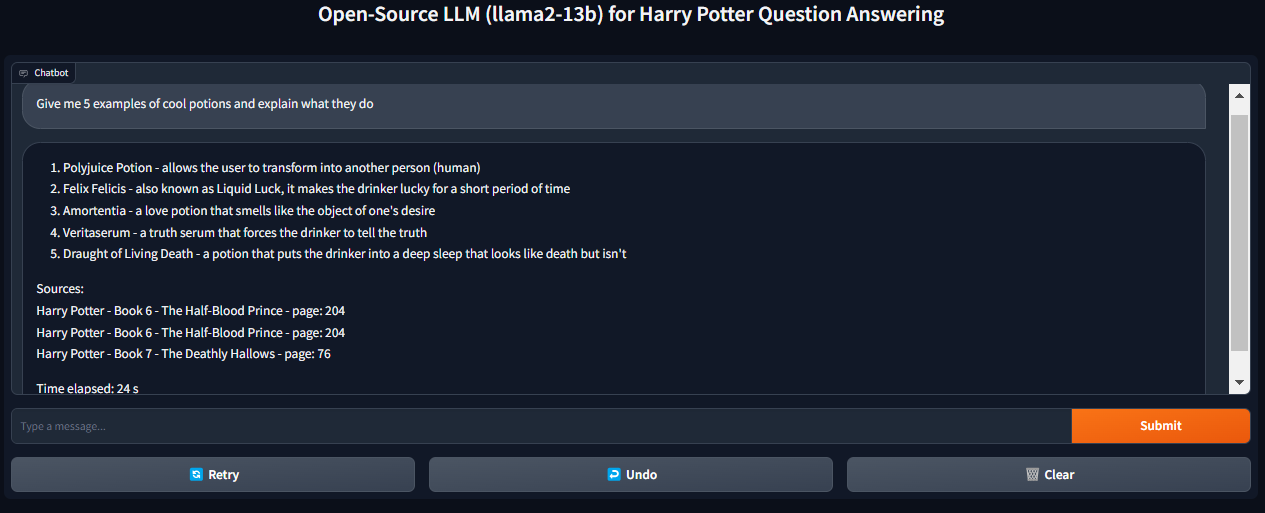